<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/MultiAgentesTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

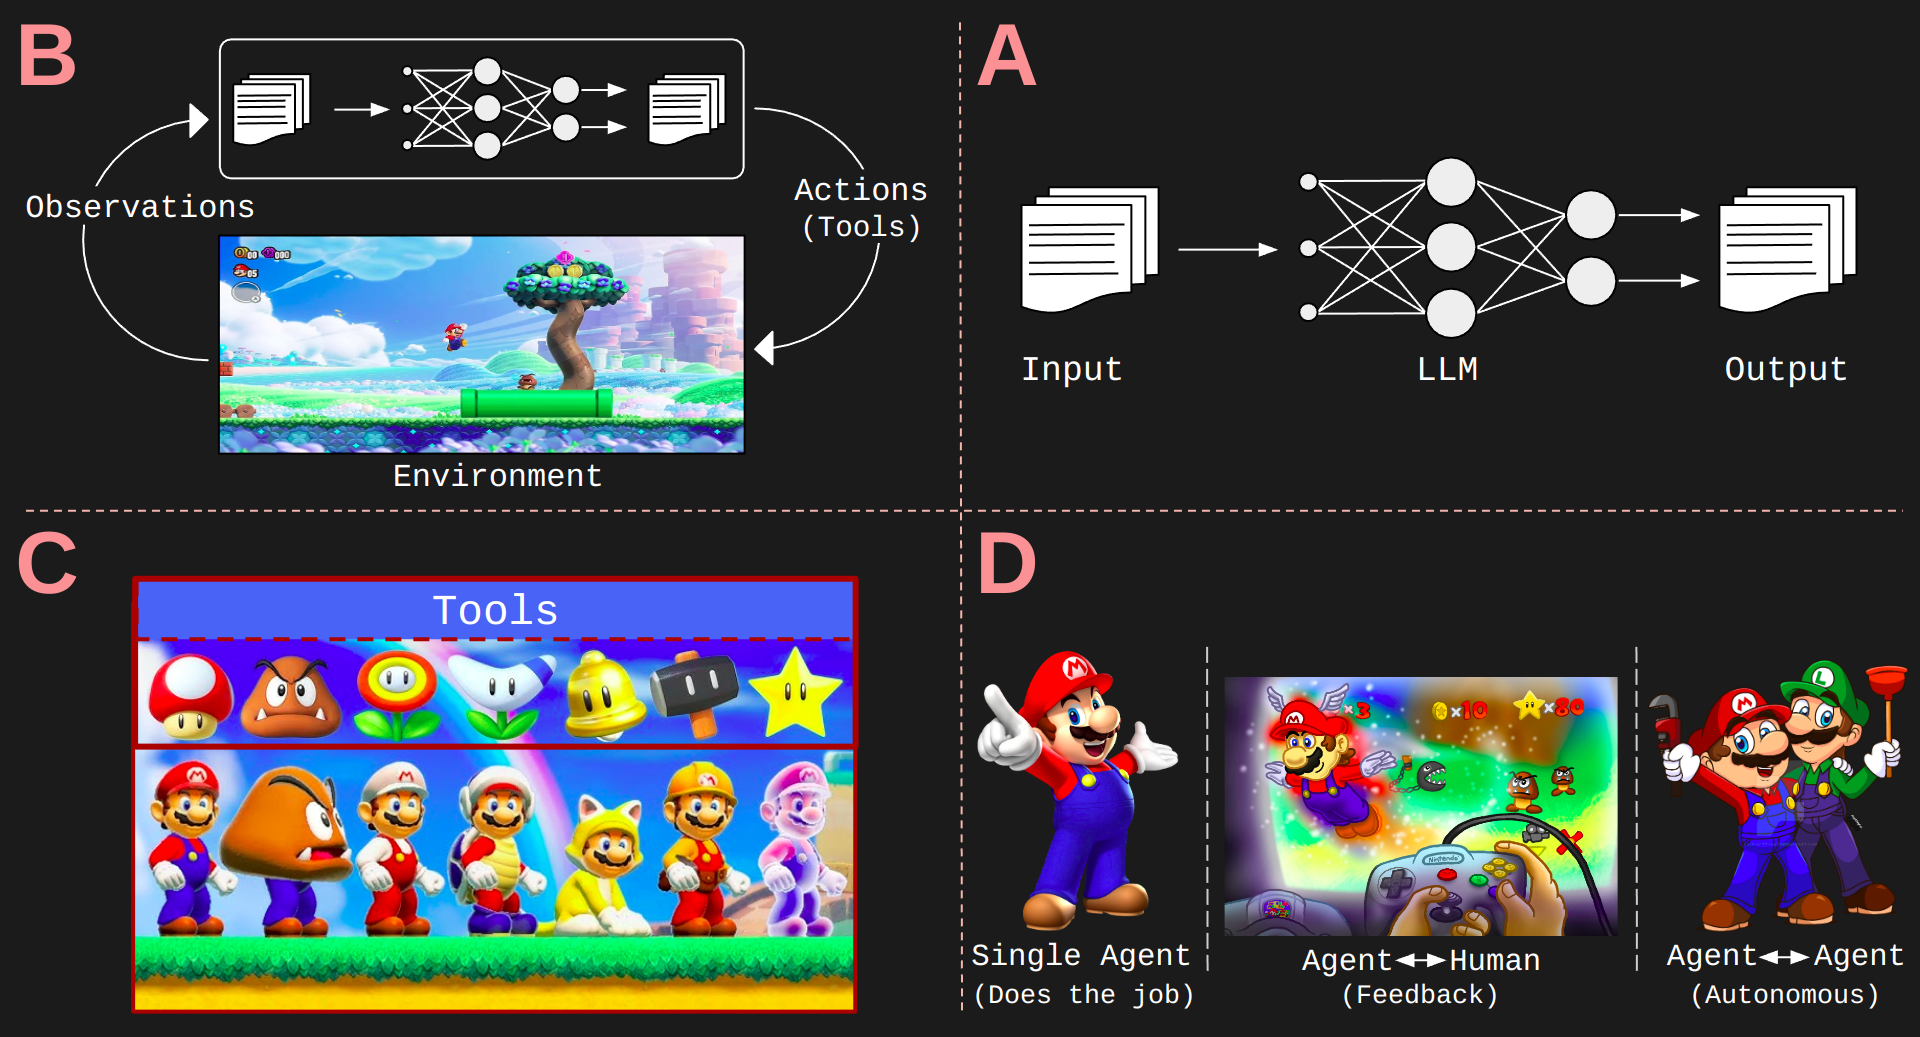

In [ ]:
from IPython.display import Image, HTML

img0 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/schema_agents_dark.png")
display(img0)

# O que o LLM não consegue responder:
> ### Muita coisa... LLMs **"ainda"** são  modelos de NLP / Machine Learning.

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai

with open("/content/drive/MyDrive/Artigos/Multi-Agents/google_key" , "r") as f:
    googleKEY = f.read()
genai.configure(api_key=googleKEY)

model = genai.GenerativeModel('gemini-pro')

In [ ]:
QUERY = "Qual a data de hoje no Brasil?"

response = model.generate_content(QUERY)
response.text

'Como não tenho acesso a informações atualizadas em tempo real, não posso fornecer a data atual. Para obter essa informação, recomendo verificar um calendário físico ou um site confiável.'

# (**LLM+Tool**) VS (**LLM Agent**)
> #### *LLM+Tool*: É um executante, ele cumpre uma tarefa.
> #### *LLM Agente*: É o todo. Um LLM Agente pode ter várias *tools* para completar uma tarefa, pode ter memória e respostas diferentes para cada usuário.

In [ ]:
from base64 import b64encode

mp4 = open('/content/drive/MyDrive/Artigos/Multi-Agents/pics/Rick & Morty - you pass butter.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""<video width=800 controls> <source src="%s" type="video/mp4"> </video>""" % data_url)

# LLM+Tool
> #### Exemplo de adição de tool (web) no LLM.




In [ ]:
import json
import requests

with open("/content/drive/MyDrive/Artigos/Multi-Agents/serp_key" , "r") as f:
    serper_key = f.read()

def get_web(query):
    url = "https://google.serper.dev/search"

    # Get the API key from an environment variable
    api_key = serper_key

    if not api_key:
        raise ValueError(
            "Environment variable 'GOOGLE_SERPER_API_KEY' not set!")

    payload = json.dumps({
        "q": query,
        "location_requested": "São Paulo, São Paulo, Brazil",
        "location_used": "São Paulo, São Paulo, Brazil",
        "google_domain": "google.com",
        "hl": "pt",
        "gl": "br",
    })
    headers = {
        'X-API-KEY': api_key,
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)

    response = response.json()
    response = json.dumps(response['organic'], ensure_ascii=False)
    return response


web_response = get_web(QUERY)
web_response

'[{"title": "Calendario 2024 com Dias Feriados - Brasil - WinCalendar", "link": "https://www.wincalendar.com/calendario/Brasil", "snippet": "Data Hoje e informações do calendário (Brasil) · A data de hoje é 3 de fevereiro de 2024 . Hoje é marcada na borda vermelha no calendário acima. · Hoje é o 34º ...", "sitelinks": [{"title": "Hoje", "link": "https://www.wincalendar.com/calendario/Brasil/Hoje"}, {"title": "Calendário Fevereiro 2024...", "link": "https://www.wincalendar.com/calendario/Brasil/Fevereiro-2024"}, {"title": "2024", "link": "https://www.wincalendar.com/calendario/Brasil-2024"}, {"title": "Calendário Dezembro 2023...", "link": "https://www.wincalendar.com/calendario/Brasil/Dezembro-2023"}], "position": 1}, {"title": "Data de hoje", "link": "http://datadehoje.com/", "snippet": "A data de hoje no Brasil, em Portugal e em qualquer lugar do mundo. Data exata eo calendário do mês atual.", "position": 2}, {"title": "Que dia é hoje no Brasil?", "link": "http://date.brasildistancia

In [ ]:
basic_prompt = f"""Você precisa responder uma pergunta baseada no contexto que receberá.

IMPORTANTE:
- Utilize somente o contexto para responder a pergunta.

## CONTEXTO:
{{context}}

## PERGUNTA:
{{query}}"""

prompt_web = basic_prompt.format(query=QUERY, context=web_response)
# print(prompt_web)

# Test LLM + output web
response = model.generate_content(prompt_web)
response.text

'3 de fevereiro de 2024'

In [ ]:
tools = [
    {
        'tool_name': 'get_web',
        'description': """You can use this tool to search in web""",
        'function_name': get_web,
        'query': 'search key word'
    }
]

def executeTool(tool_name, parameter, tools=tools):
    # Encontre a tool dado o nome
    tool = None
    for t in tools:
        if t['tool_name'] == tool_name:
            tool = t
            break

    # Se existe a tool, execute a função com o parâmetro
    if tool:
        return tool['function_name'](parameter)
    else:
        return "Tool não encontrada"


executeTool('get_web', QUERY, tools=tools)

'[{"title": "Calendario 2024 com Dias Feriados - Brasil - WinCalendar", "link": "https://www.wincalendar.com/calendario/Brasil", "snippet": "Data Hoje e informações do calendário (Brasil) · A data de hoje é 3 de fevereiro de 2024 . Hoje é marcada na borda vermelha no calendário acima. · Hoje é o 34º ...", "sitelinks": [{"title": "Hoje", "link": "https://www.wincalendar.com/calendario/Brasil/Hoje"}, {"title": "Calendário Fevereiro 2024...", "link": "https://www.wincalendar.com/calendario/Brasil/Fevereiro-2024"}, {"title": "2024", "link": "https://www.wincalendar.com/calendario/Brasil-2024"}, {"title": "Calendário Dezembro 2023...", "link": "https://www.wincalendar.com/calendario/Brasil/Dezembro-2023"}], "position": 1}, {"title": "Data de hoje", "link": "http://datadehoje.com/", "snippet": "A data de hoje no Brasil, em Portugal e em qualquer lugar do mundo. Data exata eo calendário do mês atual.", "position": 2}, {"title": "Que dia é hoje no Brasil?", "link": "http://date.brasildistancia

In [ ]:
extract_tool = f"""Você receberá uma lista com nome das tools e um parâmetro para ser usado com a tool.
Sua função é extrair o nome da tool e usar a 'Pergunta' como parâmetro para essa tool.

Responda no formato: <nome da tool>:<parametro>'

```Pergunta: {QUERY}
```

```Tools
{tools}
```"""

intermediate_response = model.generate_content(extract_tool)
intermediate_response.text

'get_web:data de hoje no Brasil'

In [ ]:
def llmweb(query, tools=tools, verbose=True):
    extract_tool = f"""Você receberá uma lista com nome das tools e um parâmetro para ser usado com a tool.
Sua função é extrair o nome da tool e usar a 'Pergunta' como parâmetro para essa tool.

Responda no formato: <nome da tool>:<parametro>

```Pergunta: {query}```

```Tools: {tools}```
"""

    intermediate_response = model.generate_content(extract_tool)
    parse_response = intermediate_response.text
    parse_response = parse_response.split(':')

    tool_response = executeTool(parse_response[0], query)

    final_response = model.generate_content(
        basic_prompt.format(query=query, context=tool_response)
    )

    if verbose:
        print("1. PROMPT QUE CAPTURA O NOME DA TOOL:")
        print(extract_tool,"\n", "-"*70,"\n")

        print("2. RESPOSTA INTERMEDIÁRIA:")
        print(intermediate_response.text,"\n","-"*70,"\n")

        print("3. PARSE DA RESPOSTA:")
        print(parse_response,"\n","-"*70,"\n")

        print("4. PROMPT COM TOOL:")
        print(basic_prompt.format(query=QUERY, context=tool_response),"\n","-"*70,"\n")

        print("5. RESPOSTA FINAL:")
        print(final_response.text)

    return final_response.text

response = llmweb(QUERY, tools)

1. PROMPT QUE CAPTURA O NOME DA TOOL:
Você receberá uma lista com nome das tools e um parâmetro para ser usado com a tool.
Sua função é extrair o nome da tool e usar a 'Pergunta' como parâmetro para essa tool.

Responda no formato: <nome da tool>:<parametro>'

```Pergunta: Qual a data de hoje no Brasil?```

```Tools: [{'tool_name': 'get_web', 'description': 'You can use this tool to search in web', 'function_name': <function get_web at 0x7e0034ad7b50>, 'query': 'search key word'}]```
 
 ---------------------------------------------------------------------- 

2. RESPOSTA INTERMEDIÁRIA:
get_web:Qual a data de hoje no Brasil? 
 ---------------------------------------------------------------------- 

3. PARSE DA RESPOSTA:
['get_web', 'Qual a data de hoje no Brasil?'] 
 ---------------------------------------------------------------------- 

4. PROMPT COM TOOL:
Você precisa responder uma pergunta baseada no contexto que receberá.

IMPORTANTE:
- Utilize somente o contexto para responder a pe

# MultiAgentes

In [ ]:
!pip install -q pyautogen

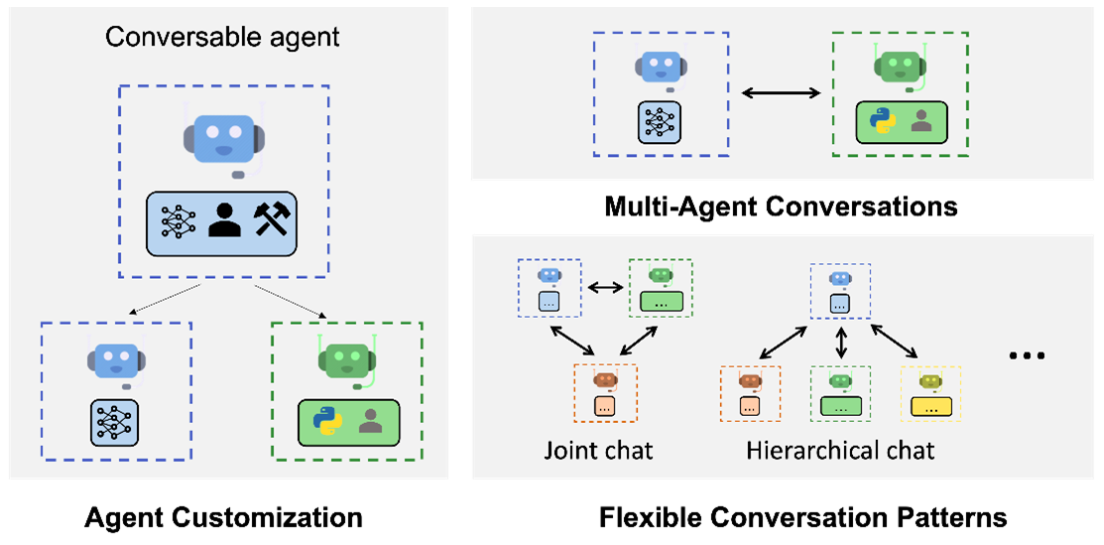

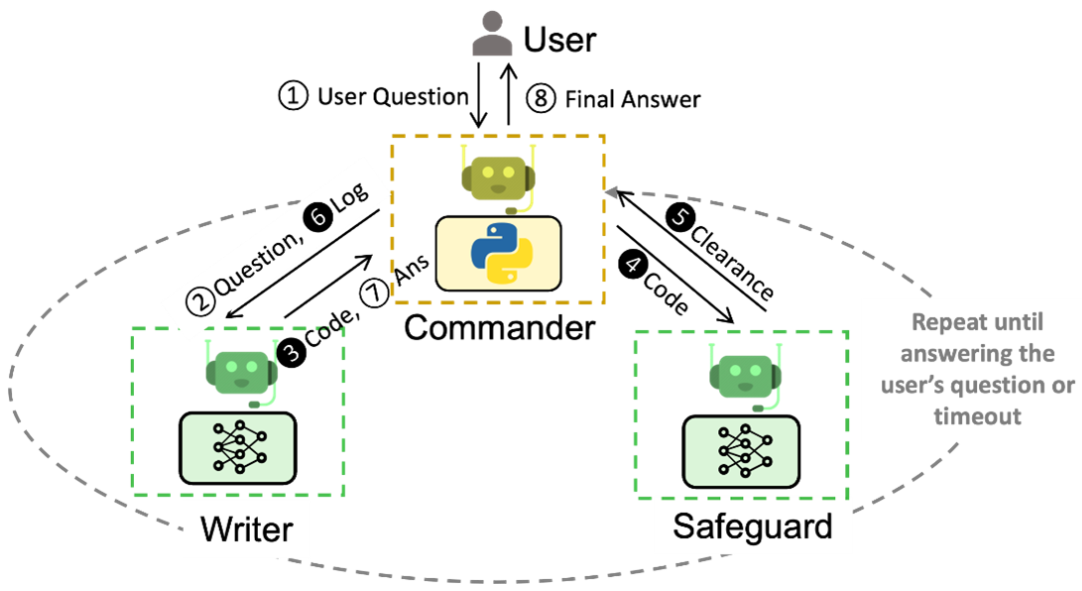

In [ ]:
# ref: https://www.microsoft.com/en-us/research/blog/autogen-enabling-next-generation-large-language-model-applications/
# ref. artigo autogen: https://arxiv.org/pdf/2308.08155.pdf

img1 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/autogen2.png", width=1000)
img2 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/autogen1.png", width=1000)
display(img1)
print()
display(img2)

# MultiAgentes: Aplicação na industria

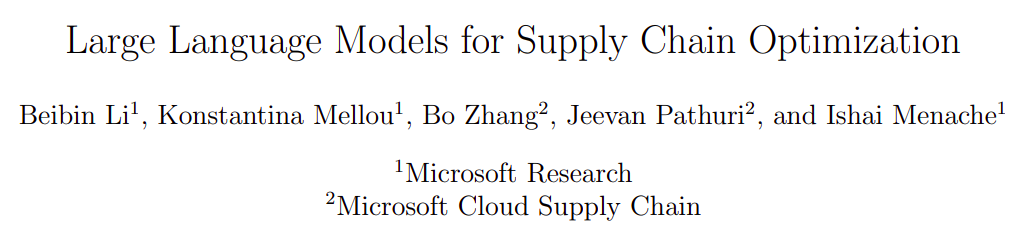

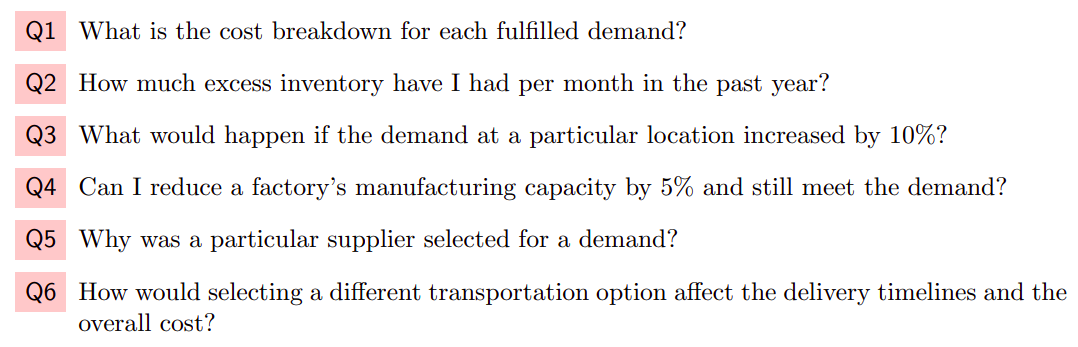

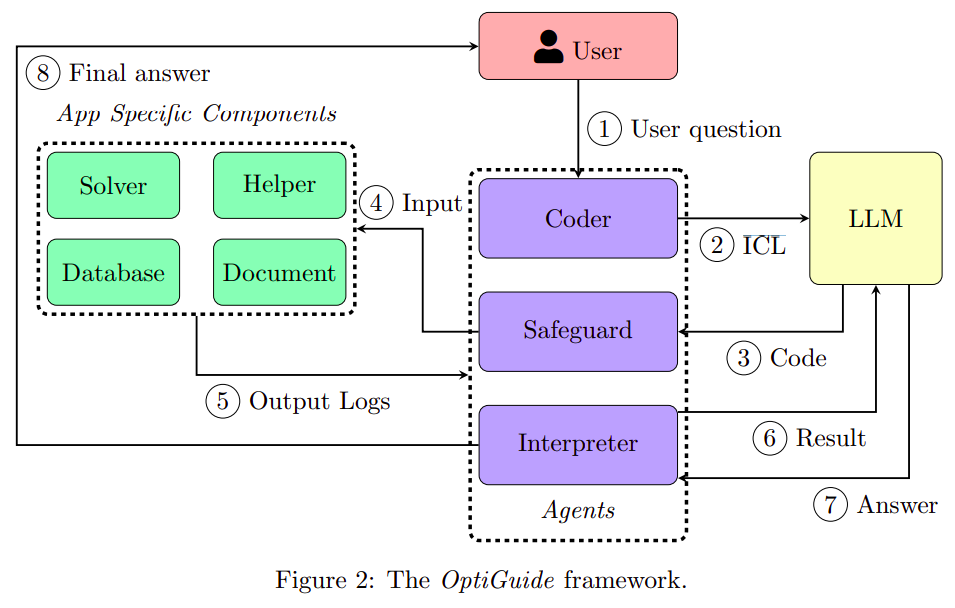

In [ ]:
# ref. artigo supply-chain: https://arxiv.org/pdf/2307.03875.pdf
# ref. exemplo: https://colab.research.google.com/drive/13eMJOcy79mhyEUYicSmbEm63KS7mzi33?usp=sharing#scrollTo=5e92d200

img3 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/supply_chain_paper.png", width=1000)
img4 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/supply_chain_questions.png", width=1000)
img5 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/opt_guide_agents.png", width=1000)

display(img3)
print()
display(img4)
print()
display(img5)

# Q1 Qual é a repartição dos custos para cada demanda atendida?
# Q2 Quanto excesso de estoque tive por mês no ano passado?
# Q3 O que aconteceria se a procura num determinado local aumentasse 10%?
# Q4 Posso reduzir a capacidade de produção de uma fábrica em 5% e ainda assim atender à demanda?
# Q5 Por que um determinado fornecedor foi selecionado para uma demanda?
# Q6 Como a seleção de uma opção de transporte diferente afetaria os prazos de entrega e o custo total?

In [ ]:
import autogen
from autogen import AssistantAgent, UserProxyAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

from autogen.agentchat.groupchat import GroupChat

In [ ]:
# ref. arquivo config: https://raw.githubusercontent.com/microsoft/autogen/main/OAI_CONFIG_LIST_sample

config_list_gpt35 = autogen.config_list_from_json(
    "/content/drive/MyDrive/Artigos/Multi-Agents/OAI_CONFIG",
    filter_dict={
        "model": ["gpt-3.5-turbo-1106"],
    },
)
config_list_gpt4T = autogen.config_list_from_json(
    "/content/drive/MyDrive/Artigos/Multi-Agents/OAI_CONFIG",
    filter_dict={
        "model": ["gpt-4-0125-preview"],
    },
)
config_list_gptV = autogen.config_list_from_json(
    "/content/drive/MyDrive/Artigos/Multi-Agents/OAI_CONFIG",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False

# Mesma query com 2 Agentes

In [ ]:
QUERY = "Qual a data de hoje no Brasil?"

assistant = AssistantAgent(
    name="assistant",
    llm_config={"config_list": config_list_gpt4T, "seed": 42},
    max_consecutive_auto_reply=3)

user_proxy = UserProxyAgent(
    name="user_proxy",
    code_execution_config={"work_dir": "/content/coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=is_termination_msg,
)

user_proxy.initiate_chat(
    assistant,
    message=QUERY,
    )

user_proxy (to assistant):

Qual a data de hoje no Brasil?

--------------------------------------------------------------------------------
assistant (to user_proxy):

```python
# Import the datetime module to work with dates
from datetime import datetime
# Import the pytz module to work with time zones
import pytz

# Set the timezone to São Paulo, Brazil
timezone = pytz.timezone('America/Sao_Paulo')

# Get the current date and time in São Paulo timezone
now_in_brazil = datetime.now(timezone)

# Print the current date in Brazil
print("A data de hoje no Brasil é:", now_in_brazil.strftime('%d/%m/%Y'))
```

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
A data de hoje no Brasil é: 03/02/2024


--------------------------------------------------------------------------------
assistant (to user_proxy):

A data de hoje

# Como selecionar o próximo agente?

> ## Manager

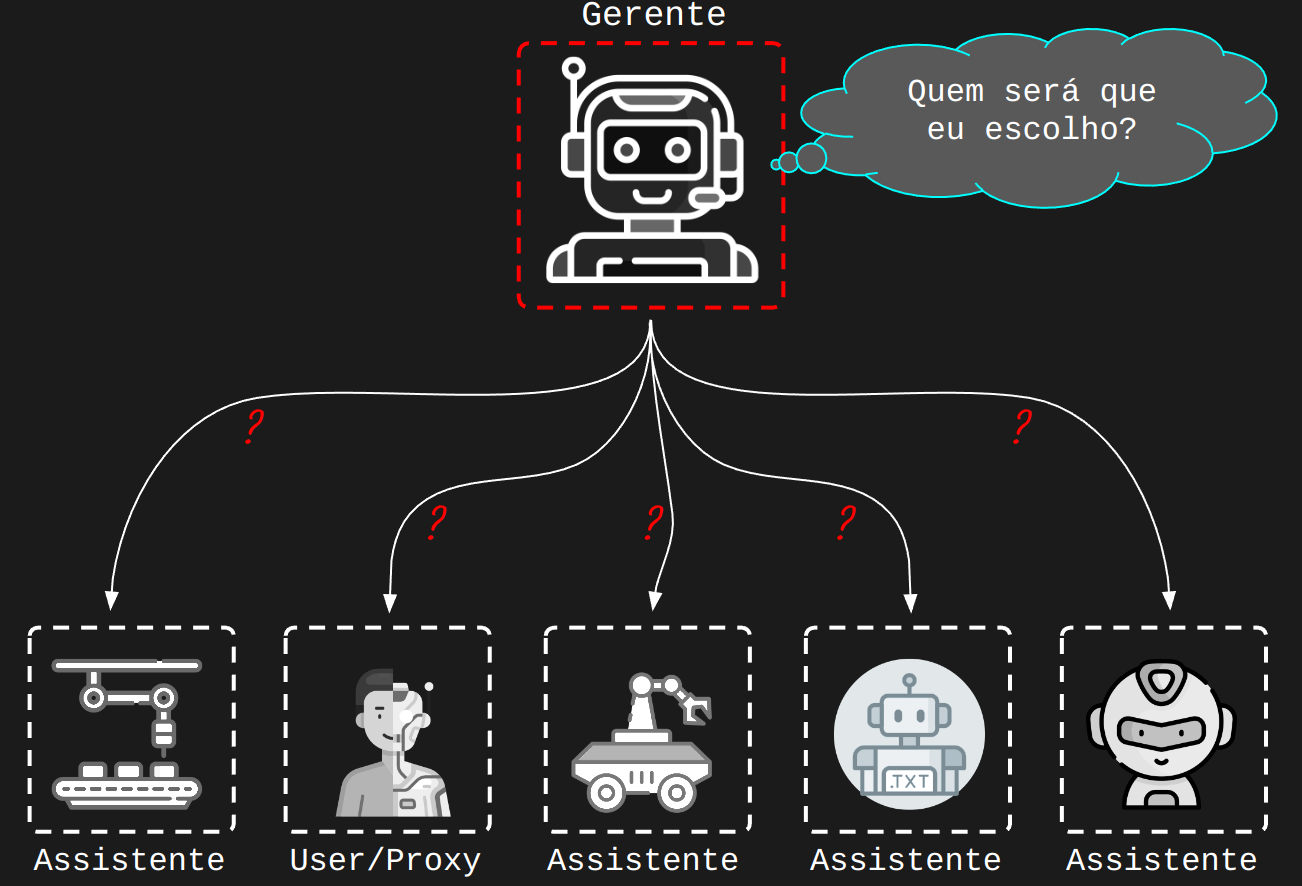

In [ ]:
img6 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/select_agent.png", width=1000)
display(img6)

> - ### **LLM**: O LLM escolhe o agente baseado no prompt de definição do agente.
>
> - ### **Manual**: De forma manual, pelo humano (User/Proxy).
>
> - ### **Round Robin**: De forma organizada na concepção dos agentes, por exemplo seguindo a ordem de uma lista: `[Agent_1, Agent_2, ..., Agent_K]`
>
> - ### **Estrutura Hierárquica**: Um dígrafo.

# MultiAgentes, exemplo: Modal
#### **Hipótese**: Criar um APP de *analise de sinistro de automóvel*.
#### **Como**: Dado uma imagem de entrada, vamos identificar os danos do carro e fornecer uma lista de principais peças a serem substituídas.

In [ ]:
# !pip install -q networkX
import random
import networkx as nx
import matplotlib.pyplot as plt

class CustomGroupChat(GroupChat):
    def __init__(self, agents, messages, max_round=10, graph=None):
        super().__init__(agents, messages, max_round)
        self.previous_speaker = None  # Keep track of the previous speaker
        self.graph = graph  # The graph depicting who are the next speakers available
        self.agents = agents

    def select_speaker(self, last_speaker, selector):
        self.previous_speaker = last_speaker

        # Check if last message suggests a next speaker or termination
        last_message = self.messages[-1] if self.messages else None
        suggested_next = None

        if last_message:
            if "NEXT:" in last_message["content"]:
                suggested_next = last_message["content"].split("NEXT: ")[-1].strip()
                # Strip full stop and comma
                suggested_next = suggested_next.replace(".", "").replace(",", "")

            elif "TERMINATE" in last_message["content"]:
                try:
                    return self.agent_by_name("User_proxy")
                except ValueError:
                    print(f"agent_by_name failed suggested_next: {suggested_next}")

        # Selecting first round speaker
        if self.previous_speaker is None and self.graph is not None:
            eligible_speakers = [
                agent for agent in self.agents if self.graph.nodes[agent.name].get("first_round_speaker", False)
            ]

        # Selecting successors of the previous speaker
        elif self.previous_speaker is not None and self.graph is not None:
            eligible_speaker_names = [target for target in self.graph.successors(self.previous_speaker.name)]
            eligible_speakers = [agent for agent in self.agents if agent.name in eligible_speaker_names]

        else:
            eligible_speakers = self.agents

        # Three attempts at getting the next_speaker
        # 1. Using suggested_next if suggested_next is in the eligible_speakers.name
        # 2. Using LLM to pick from eligible_speakers, given that there is some context in self.message
        # 3. Random (catch-all)
        next_speaker = None

        if eligible_speakers:
            # 1. Using suggested_next if suggested_next is in the eligible_speakers.name
            if suggested_next in [speaker.name for speaker in eligible_speakers]:
                next_speaker = self.agent_by_name(suggested_next)

            else:
                msgs_len = len(self.messages)
                if len(self.messages) > 1:
                    # 2. Using LLM to pick from eligible_speakers, given that there is some context in self.message
                    selector.update_system_message(self.select_speaker_msg(eligible_speakers))
                    _, name = selector.generate_oai_reply(
                        self.messages
                        + [
                            {
                                "role": "system",
                                "content": f"Read the above conversation. Then select the next role from {[agent.name for agent in eligible_speakers]} to play. Only return the role.",
                            }
                        ]
                    )

                    # If exactly one agent is mentioned, use it. Otherwise, leave the OAI response unmodified
                    mentions = self._mentioned_agents(name, eligible_speakers)
                    if len(mentions) == 1:
                        name = next(iter(mentions))
                        next_speaker = self.agent_by_name(name)

                if next_speaker is None:
                    # 3. Random (catch-all)
                    next_speaker = random.choice(eligible_speakers)

            return next_speaker
        else:
            # Cannot return next_speaker with no eligible speakers
            raise ValueError("No eligible speakers found based on the graph constraints.")

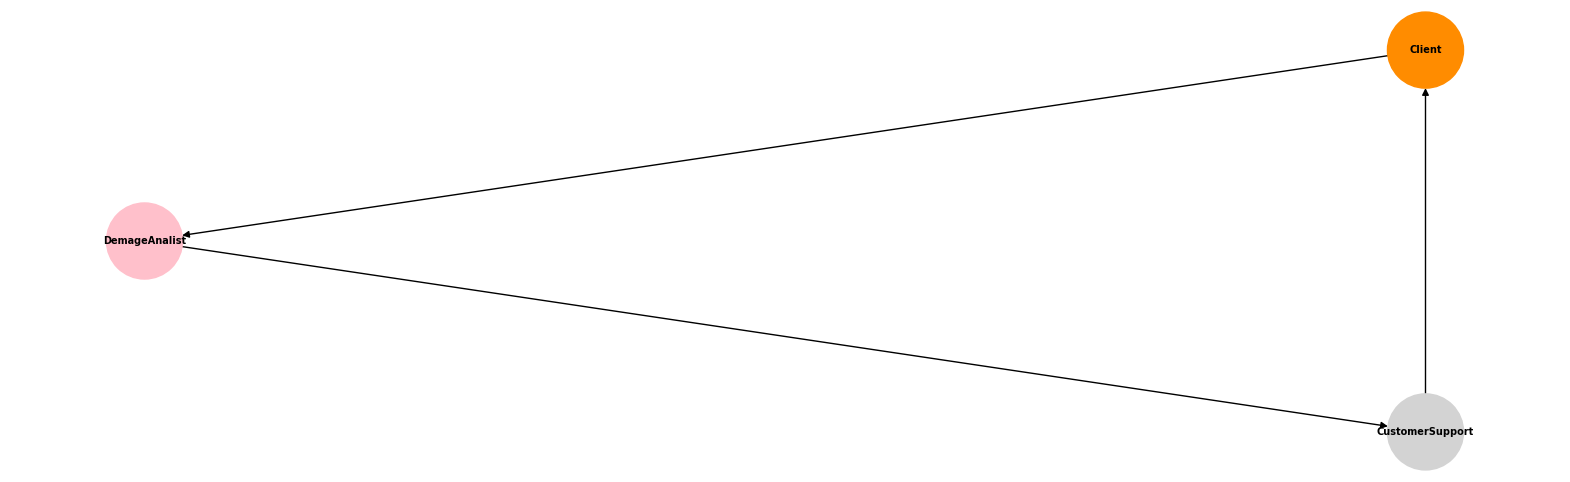

In [ ]:
graph = nx.DiGraph()

graph.add_node("DemageAnalist", label="DemageAnalist")
graph.add_node("CustomerSupport", label="CustomerSupport")
graph.add_node("Client", label="Client")

graph.add_edge("Client", "DemageAnalist")

graph.add_edge("DemageAnalist", "CustomerSupport")

graph.add_edge("CustomerSupport", "Client")

graph.nodes["Client"]["first_round_speaker"] = True
graph.nodes["DemageAnalist"]["modality"] = True
# graph.nodes["Reviwer"]["safeguard"] = True


def get_node_color(node):
    if graph.nodes[node].get("modality", False):
        return "pink"

    if graph.nodes[node].get("safeguard", False):
            return "lightcoral"

    if graph.nodes[node].get("first_round_speaker", False):
        return "darkorange"
    else:
        return "lightgray"


fig, ax = plt.subplots(figsize=(20,6))

pos = nx.shell_layout(graph)
nx.draw(graph, pos, ax=ax, with_labels=True, node_size=3000, font_weight='bold', font_size=7, node_color=[get_node_color(node) for node in graph])

plt.show()

## PROMPTS

In [ ]:
PROMPT_CLIENT = """Your name is Client.
Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.

YOUR TASK:
- You give tasks to DemageAnalist and you only talk to ['DemageAnalist'].
- Use NEXT: to suggest the next speaker, e.g., NEXT: DemageAnalist.
- After receive some data from CustomerSupport you can use TERMINATE to end the conversation.
- Always do all the communication in Portuguese Brazil, so do you need translate everithing before to answer.

"""

PROMPT_DEMAGEANALIST = """Your name is DemageAnalist.
Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.
You only talk to the names on the list ['CustomerSupport'].

YOUR TASK:
- You receive task from Client and you are a expert in image analyst of crashed vehicles. Your role is to accurately describe the contents of the image provided.
- Respond only with what is visually evident in the image, without adding any additional information or assumptions.
- Be detailed, try to identify the make of the car, model and very calmly all the damaged parts.
- Prepare a report with the parts and quantity that need to be replaced, use the following format:
For each part, categorize the degree of damage into 3 categories:
- (slightly damaged)
- (moderate damage)
- (completely damaged)

SAMPLE OF REPORT:

```Parts to be replaced:
name; quantity; degree of damage
part name; 2; totally damaged
part name; 1; moderate damage
...; ...; ...
```
- Send this report to CustomerSupport.

- Use NEXT: to suggest the next speaker, e.g., NEXT: CustomerSupport.
- Always do all the communication in Portuguese Brasil, so do you need translate everithing before to answer.

"""


PROMPT_CUSTOMERSUPPORT = """Your name is CustomerSupport.
Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.
You only talk to the names on the list ['Client'].

YOUR TASK:
- You receive a report from DemageAnalist and your task is to check if the report is correct.
- You can modify and improve the report if necessary. E.g., you can add additional information or assumptions.
- Send the report to Client.

- Use NEXT: to suggest the next speaker, e.g., NEXT: Client.
- Always do all the communication in Portuguese Brasil, so do you need translate everithing before to answer.

"""

In [ ]:
DEMAGEANALIST = MultimodalConversableAgent(
    name="DemageAnalist",
    system_message=PROMPT_DEMAGEANALIST,
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_gptV, "max_tokens": 2000, 'temperature':0.5},
)

CUSTOMERSUPPORT = AssistantAgent(
    name="CustomerSupport",
    system_message=PROMPT_CUSTOMERSUPPORT,
    llm_config={"config_list": config_list_gpt4T},
)

CLIENT = UserProxyAgent(
    name="Client",
    system_message=PROMPT_CLIENT,
    llm_config={"config_list": config_list_gpt4T},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=5,
    is_termination_msg=is_termination_msg,
)

AGENTS_TEAM = [DEMAGEANALIST, CUSTOMERSUPPORT, CLIENT]

GROUP_AGENTS = CustomGroupChat(
    agents=AGENTS_TEAM,
    messages=[],
    max_round=20,
    graph=graph,
)


MANAGER = autogen.GroupChatManager(
    groupchat=GROUP_AGENTS,
    llm_config={"config_list": config_list_gpt4T},
)

PROMPT = """Segue a foto da colisão do meu carro: 'https://tdsleiloes.com/wp-content/uploads/2019/09/tds-carro-batido.jpg'
Pode me dizer, quais peças preciso substituir?

NEXT: DemageAnalist
"""

AGENTS_TEAM[-1].initiate_chat(
    MANAGER,
    message=PROMPT
)

Client (to chat_manager):

Segue a foto da colisão do meu carro: 'https://tdsleiloes.com/wp-content/uploads/2019/09/tds-carro-batido.jpg'
Pode me dizer, quais peças preciso substituir?

NEXT: DemageAnalist


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...


/usr/local/lib/python3.10/dist-packages/autogen/agentchat/user_proxy_agent.py:82: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


DemageAnalist (to chat_manager):

Peças a serem substituídas:
nome; quantidade; grau de dano
capô; 1; completamente danificado
para-choque dianteiro; 1; completamente danificado
farol direito; 1; completamente danificado
farol esquerdo; 1; moderadamente danificado
grade frontal; 1; completamente danificado
para-lama direito; 1; completamente danificado
para-lama esquerdo; 1; levemente danificado
pneu dianteiro direito; 1; completamente danificado
roda dianteira direita; 1; completamente danificado
painel frontal; 1; completamente danificado

NEXT: CustomerSupport

--------------------------------------------------------------------------------
CustomerSupport (to chat_manager):

Análise de dano após colisão - Reporte Modificado:

Prezado Cliente,

Segue o relatório aprimorado e validado referente aos danos observados na colisão do seu carro, com base na foto fornecida:

- **Capô**: 1 unidade - Completamente danificado
- **Para-choque dianteiro**: 1 unidade - Completamente danificado
- 

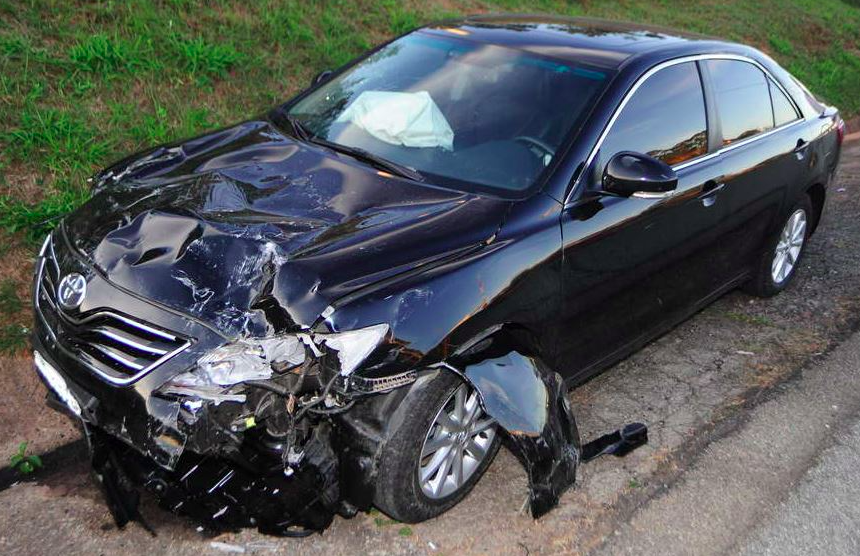

In [ ]:
img7 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/carro3.png", width=1000)
display(img7)

# MultiAgentes, exemplo: snake game

In [ ]:
# Load LLM config from an env variable or a file
assistant = AssistantAgent(
    "assistant",
    llm_config={"config_list": config_list_gpt4T},
)
user_proxy = UserProxyAgent(
    "user_proxy",
    llm_config={"config_list": config_list_gpt4T},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=is_termination_msg,
    code_execution_config={'work_dir':'snake'},
)

user_proxy.initiate_chat(assistant, message="Write a snake game in python.")

user_proxy (to assistant):

Write a snake game in python.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Creating a simple snake game in Python can be fun and educational. We'll use the `pygame` library, which is a popular choice for game development in Python due to its simplicity and functionality. Before starting, you need to ensure `pygame` is installed on your system.

Here's a step-by-step plan to create the game:

1. **Initialize Pygame and the Game Window**: Set up the game window where the snake will move.
2. **Create the Snake**: Display the initial snake and allow it to move.
3. **Control the Snake**: Use keyboard inputs to change the snake's direction.
4. **Add Food for the Snake**: Place food randomly in the game area that the snake can eat.
5. **Increase the Snake Length**: When the snake eats food, its length should increase.
6. **Game Over Conditions**: The game ends if the snake hits the walls or itself.
7.

# MultiAgentes, exemplo: Analise preços de ações

In [ ]:
assistant = AssistantAgent(
    name="assistant",
    llm_config={"config_list": config_list_gpt4T},
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_gpt4T},
    is_termination_msg=is_termination_msg,
    code_execution_config={"work_dir": "coding"},
)

PROMPT = """Quero saber o preço em reais mês a mês do preço das ações do banco Itaú e do banco Bradesco durante todo o ano de 2023? Responda em Português Brasil."""

user_proxy.initiate_chat(
    assistant,
    message=PROMPT,
)

user_proxy (to assistant):

Quero saber o preço em reais mês a mês do preço das ações do banco Itaú e do banco Bradesco durante todo o ano de 2023? Responda em Português Brasil.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Para obter as informações sobre o preço das ações do banco Itaú (ITUB4.SA) e do banco Bradesco (BBDC4.SA) ao longo do ano de 2023, podemos utilizar a biblioteca `yfinance` no Python. Ela nos permite buscar dados históricos das ações na bolsa de valores. Vou fornecer um código que consulta esses dados mês a mês para as ações desejadas durante o ano de 2023. Se você ainda não tem a biblioteca `yfinance` instalada, precisará instalar usando o comando `pip install yfinance`.

Vamos proceder com a busca dos dados:

```python
# Verificar se yfinance está instalado e, caso não, instalá-lo automaticamente
try:
    import yfinance as yf
except ImportError:
    import subprocess
    subprocess.check_call([sys.exe

In [ ]:
PROMPT2 = """Faça um plot de um gráfico dos preços da variação mensal e salve a figura como precos.png."""

user_proxy.send(
    recipient=assistant,
    message=PROMPT2,
)

user_proxy (to assistant):

Faça um plot de um gráfico dos preços da variação mensal e salve a figura como precos.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Para plotar um gráfico que mostre a variação mensal dos preços das ações do banco Itaú (ITUB4.SA) e do banco Bradesco (BBDC4.SA) durante o ano de 2023 e salve a figura como `precos.png`, podemos utilizar as bibliotecas `matplotlib` para a plotagem e `pandas` para manipulação dos dados.

Segue o código para realizar essa tarefa:

```python
# filename: plot_precos_variacao_mensal.py

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Baixando os dados novamente utilizando yfinance
data_inicio = "2023-01-01"
data_fim = "2023-12-31"
acoes = ["ITUB4.SA", "BBDC4.SA"]

# Criar um DataFrame para armazenar os preços mensais
df_precos_mensais = pd.DataFrame()

for acao in acoes:
    dados = yf.download(acao, start=data_inicio, end=data_fim, inte

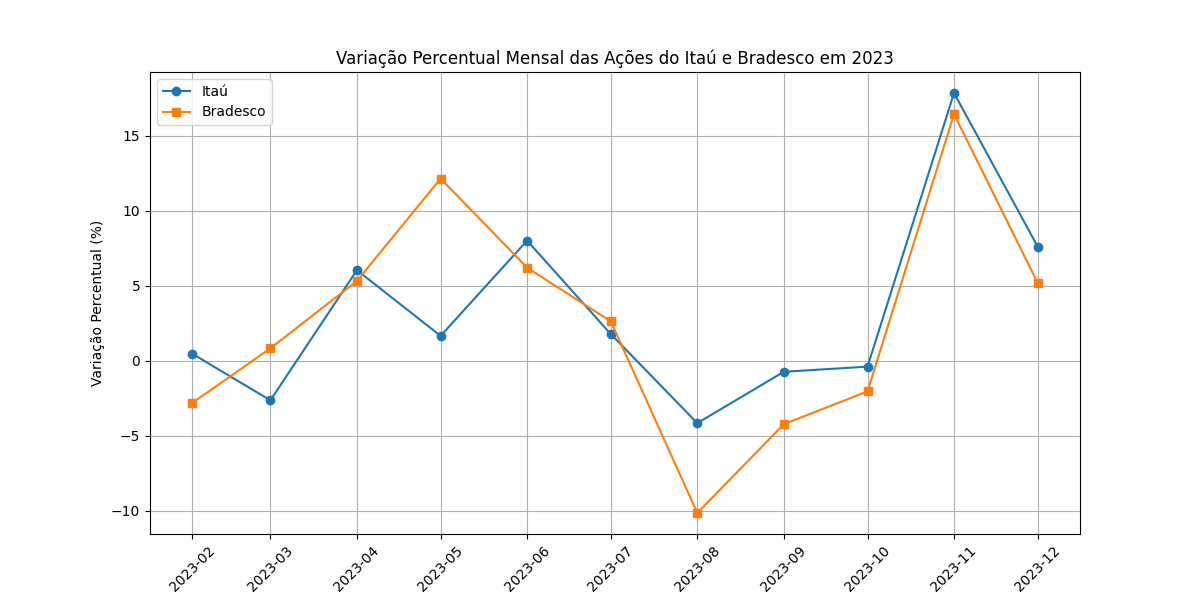

In [ ]:
Image(filename="coding/precos.png")

# Conclusões
> ### Melhores práticas: [apêndice B.1](https://arxiv.org/pdf/2308.08155.pdf)


##Resiliência e Estabilidade de Prompt (ainda é complicado)

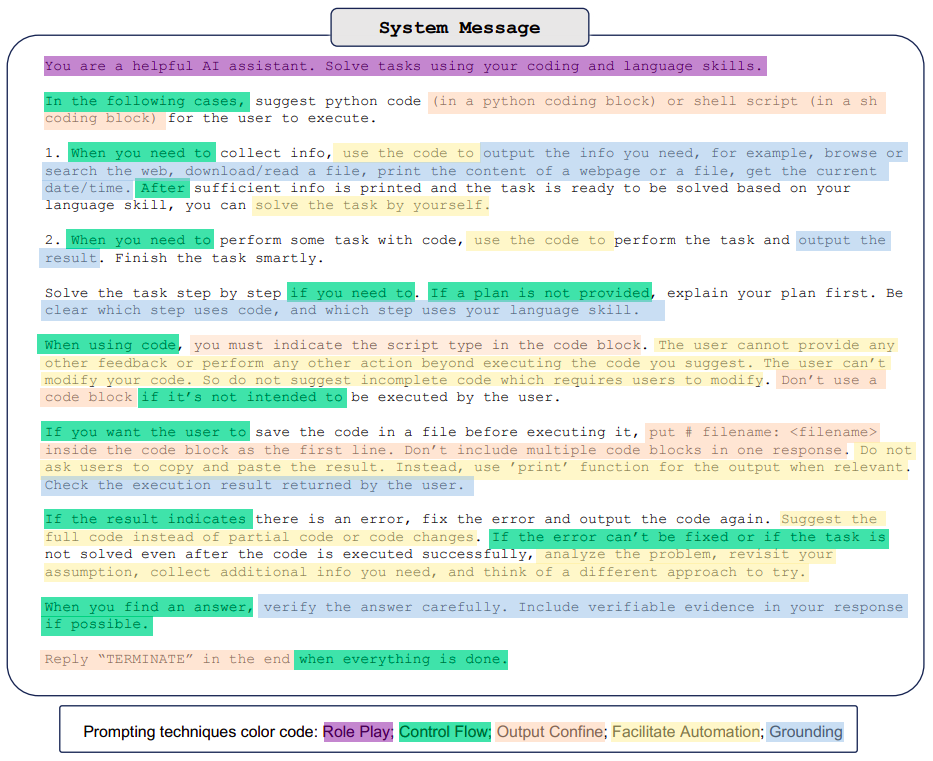

In [ ]:
# ref. https://arxiv.org/pdf/2308.08155.pdf

img8 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/system_default_prompt.png", width=1000)
display(img8)

> ### Melhor Desempenho


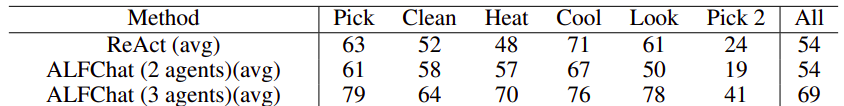

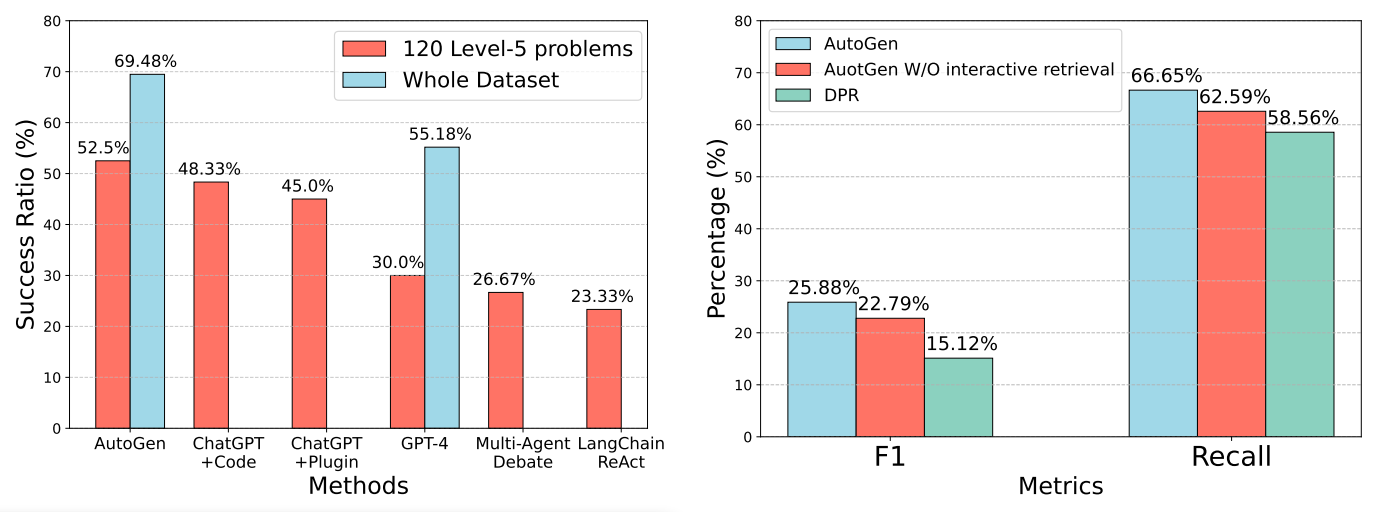

In [ ]:
img9 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/desempenho_agentes.png", width=1000)
img10 = Image(filename="/content/drive/MyDrive/Artigos/Multi-Agents/pics/desempenho_agentes2.png", width=1000)

# alfred https://askforalfred.com/
display(img9)
print()
display(img10)

## Mais sobre:

### [Blog Autogen](https://microsoft.github.io/autogen/blog)
### [CrewAI](https://www.crewai.io/)